In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3a
commitnumber = 5014a19
conc = None
dv = 0.01
klin = 0
molecule = h2o
ng_adju = [0, 0]
ng_refs = [2, 6]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(10, 250), (600, 250)]
tsfc = 257
vmax = 620
vmin = 540
w_diffuse = [(1.9, 1.7), (1.4, 1.4, 1.4, 1.55, 1.6, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.5, 0.5, 0.5, 0.5, 0.5)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

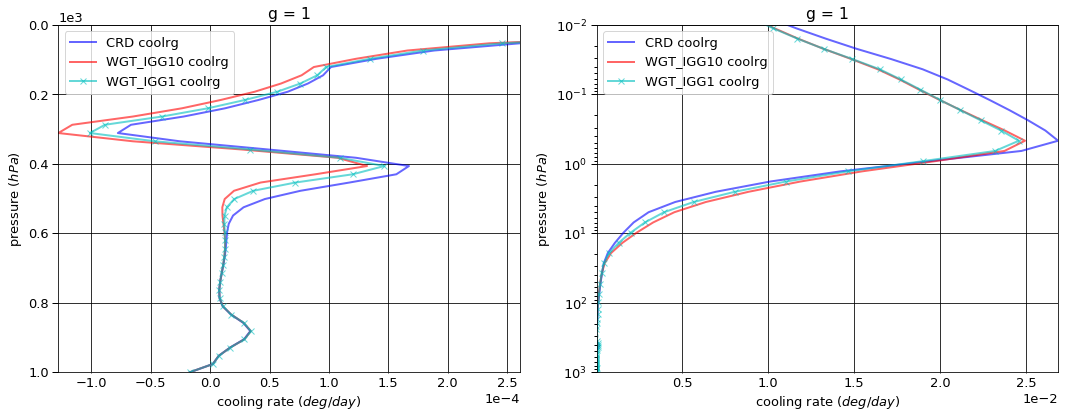

# Figure: cooling rate g-group 2

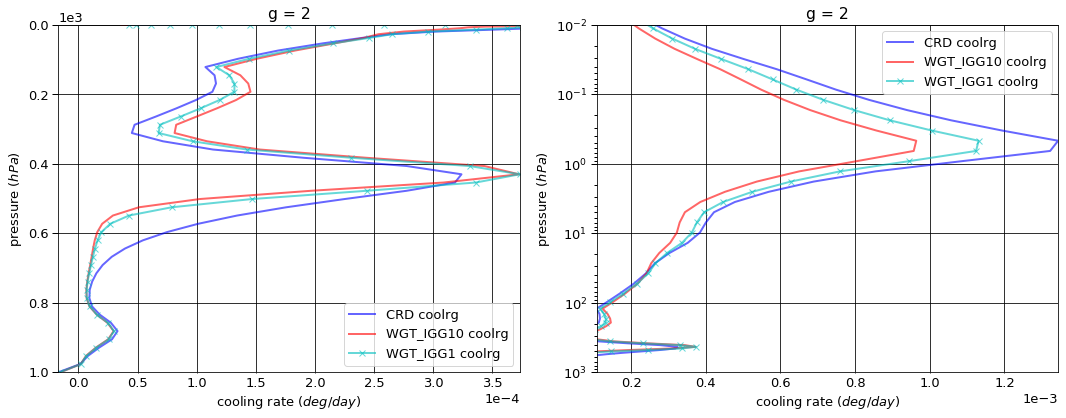

# Figure: cooling rate g-group 3

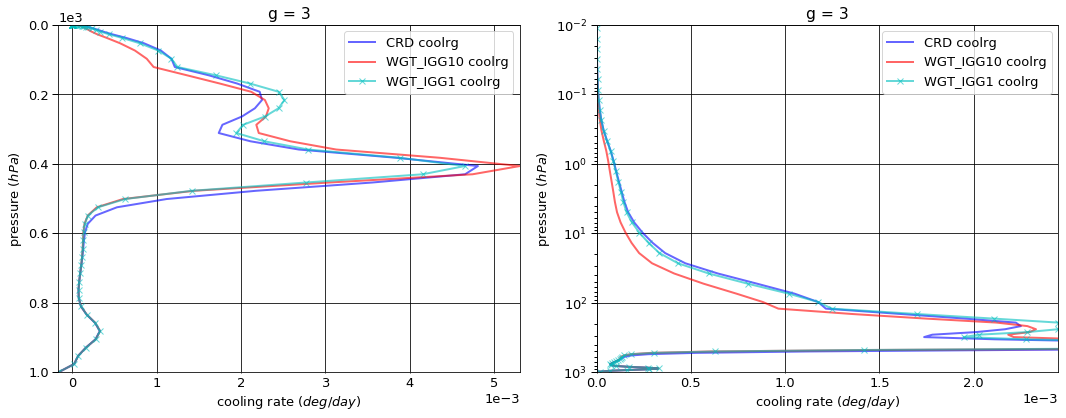

# Figure: cooling rate g-group 4

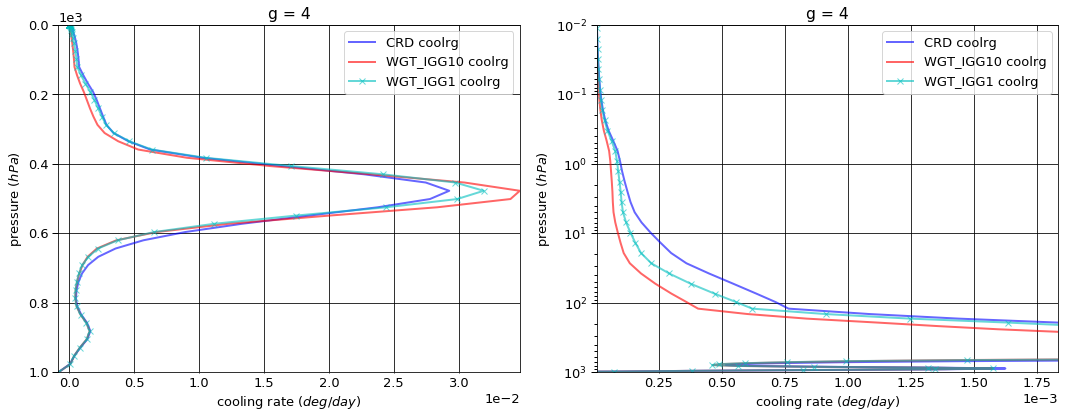

# Figure: cooling rate g-group 5

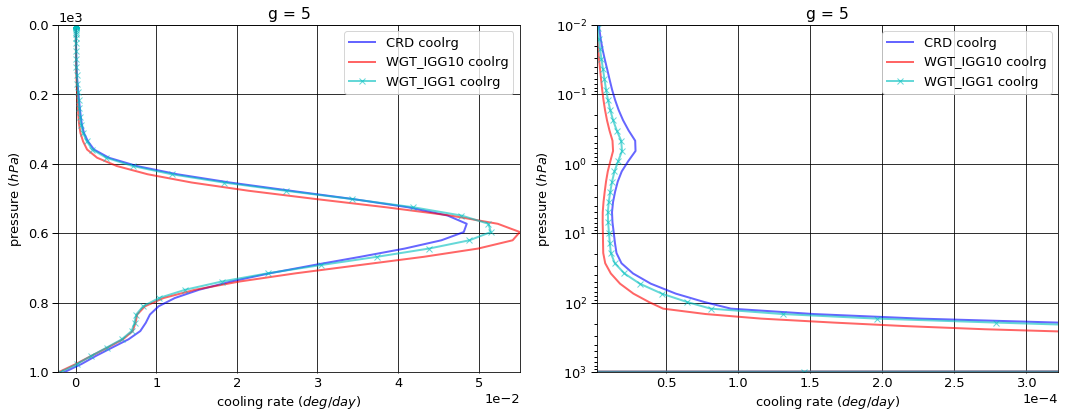

# Figure: cooling rate g-group 6

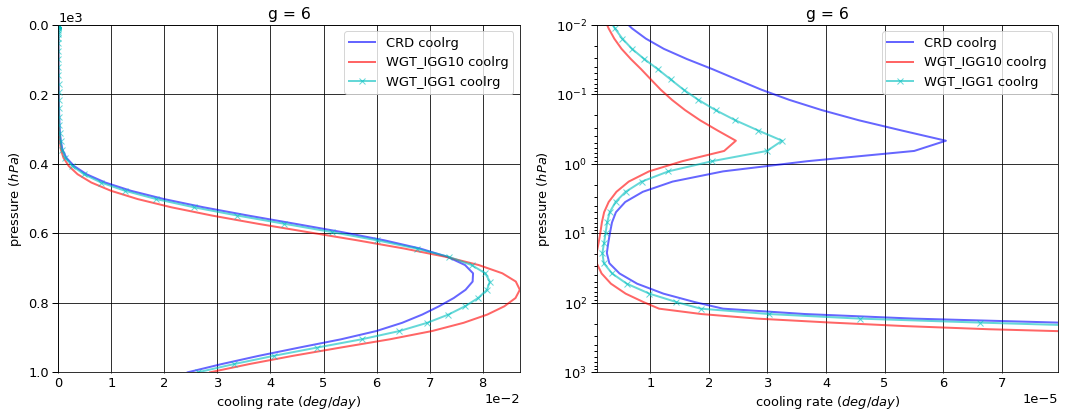

# Figure: cooling rate g-group 7

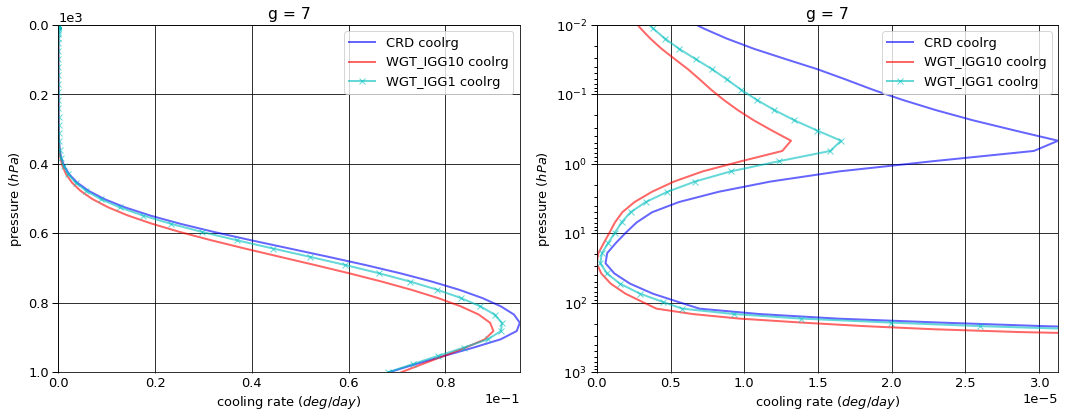

# Figure: cooling rate g-group 8

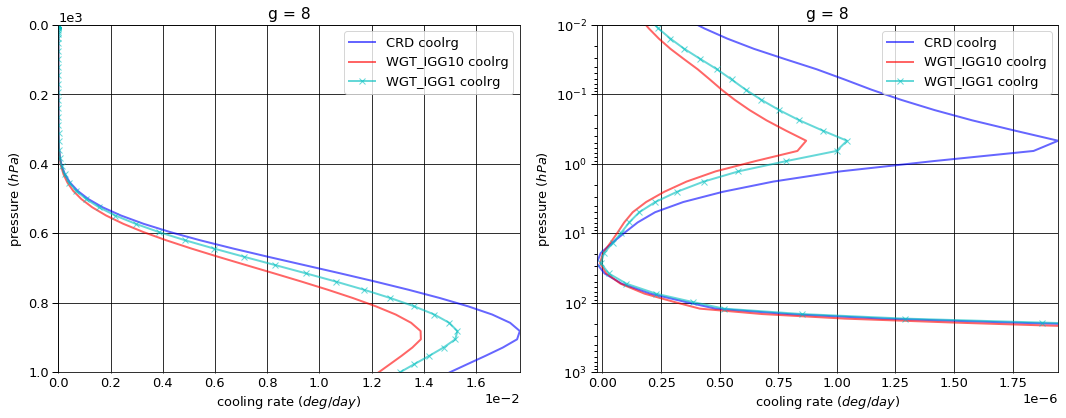

# Figure: cooling rate g-group total

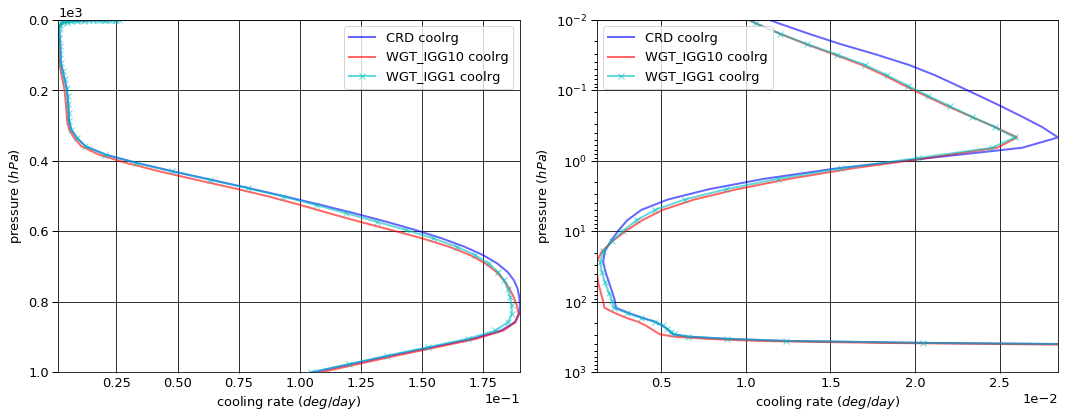

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014491  0.000000  -0.014491
  1013.0   76     -0.023742  0.023853   0.000111
2 0.0      1      -0.012504  0.000000  -0.012504
  1013.0   76     -0.020637  0.020751   0.000114
3 0.0      1      -0.136147  0.000000  -0.136147
  1013.0   76     -0.228110  0.229179   0.001069
4 0.0      1      -0.704729  0.000000  -0.704729
  1013.0   76     -0.988750  0.994208   0.005458
5 0.0      1      -1.584128  0.000000  -1.584128
  1013.0   76     -1.883697  1.898916   0.015219
6 0.0      1      -4.207197  0.000000  -4.207197
  1013.0   76     -4.454694  3.796538  -0.658156
7 0.0      1     -10.530004  0.000000 -10.530004
  1013.0   76    -10.660456  4.115049  -6.545407
8 0.0      1      -5.315262  0.000000  -5.315262
  1013.0   76     -5.331052  0.703018  -4.628034


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014214  0.000000  -0.014214
  1013.0   76     -0.023771  0.023883   0.000112
2 0.0      1      -0.011879  0.000000  -0.011879
  1013.0   76     -0.020637  0.020735   0.000098
3 0.0      1      -0.134193  0.000000  -0.134193
  1013.0   76     -0.228320  0.229396   0.001076
4 0.0      1      -0.709395  0.000000  -0.709395
  1013.0   76     -0.989540  0.994822   0.005282
5 0.0      1      -1.600750  0.000000  -1.600750
  1013.0   76     -1.885506  1.906365   0.020859
6 0.0      1      -4.245196  0.000000  -4.245196
  1013.0   76     -4.458926  3.951635  -0.507291
7 0.0      1     -10.567504  0.000000 -10.567504
  1013.0   76    -10.664791  3.706732  -6.958060
8 0.0      1      -5.308027  0.000000  -5.308027
  1013.0   76     -5.319646  0.549193  -4.770453


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.014215  0.000000  -0.014215
  1013.0   76     -0.023771  0.023883   0.000112
2 0.0      1      -0.012036  0.000000  -0.012036
  1013.0   76     -0.020637  0.020737   0.000100
3 0.0      1      -0.132995  0.000000  -0.132995
  1013.0   76     -0.228320  0.229396   0.001076
4 0.0      1      -0.698145  0.000000  -0.698145
  1013.0   76     -0.989540  0.994815   0.005275
5 0.0      1      -1.578928  0.000000  -1.578928
  1013.0   76     -1.885506  1.904872   0.019366
6 0.0      1      -4.218026  0.000000  -4.218026
  1013.0   76     -4.458926  3.886622  -0.572304
7 0.0      1     -10.544383  0.000000 -10.544383
  1013.0   76    -10.664791  3.927354  -6.737438
8 0.0      1      -5.305487  0.000000  -5.305487
  1013.0   76     -5.319646  0.614621  -4.705025


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      2.765280e-04  0.000000  2.765280e-04
  1013.0   76    -2.959300e-05  0.000031  9.254700e-07
2 0.0      1      6.247080e-04  0.000000  6.247080e-04
  1013.0   76     5.140000e-07 -0.000016 -1.544373e-05
3 0.0      1      1.953630e-03  0.000000  1.953630e-03
  1013.0   76    -2.099300e-04  0.000217  7.289800e-06
4 0.0      1     -4.665880e-03  0.000000 -4.665880e-03
  1013.0   76    -7.900400e-04  0.000614 -1.762991e-04
5 0.0      1     -1.662200e-02  0.000000 -1.662200e-02
  1013.0   76    -1.809500e-03  0.007449  5.639319e-03
6 0.0      1     -3.799900e-02  0.000000 -3.799900e-02
  1013.0   76    -4.232400e-03  0.155097  1.508643e-01
7 0.0      1     -3.750000e-02  0.000000 -3.750000e-02
  1013.0   76    -4.335000e-03 -0.408317 -4.126524e-01
8 0.0      1      7.235000e-03  0.000000  7.235000e-03
  1013.0   76     1.140620e-02 -0.153824 -1.424183e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      2.762950e-04  0.000000  2.762950e-04
  1013.0   76    -2.959300e-05  0.000031  9.606500e-07
2 0.0      1      4.673240e-04  0.000000  4.673240e-04
  1013.0   76     5.140000e-07 -0.000014 -1.338740e-05
3 0.0      1      3.151420e-03  0.000000  3.151420e-03
  1013.0   76    -2.099300e-04  0.000218  7.911400e-06
4 0.0      1      6.584250e-03  0.000000  6.584250e-03
  1013.0   76    -7.900400e-04  0.000607 -1.831752e-04
5 0.0      1      5.200400e-03  0.000000  5.200400e-03
  1013.0   76    -1.809500e-03  0.005956  4.146792e-03
6 0.0      1     -1.082940e-02  0.000000 -1.082940e-02
  1013.0   76    -4.232400e-03  0.090084  8.585140e-02
7 0.0      1     -1.437900e-02  0.000000 -1.437900e-02
  1013.0   76    -4.335000e-03 -0.187695 -1.920304e-01
8 0.0      1      9.774100e-03  0.000000  9.774100e-03
  1013.0   76     1.140620e-02 -0.088396 -7.699020e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      2.494756e-03
  1001.112500 75    -1.717644e-05
2 0.000312    1      4.213830e-05
  1001.112500 75    -1.700235e-05
3 0.000312    1      5.206284e-09
  1001.112500 75    -1.652823e-04
4 0.000312    1      5.331364e-07
  1001.112500 75    -8.410109e-04
5 0.000312    1      3.217554e-07
  1001.112500 75    -1.455573e-03
6 0.000312    1      1.840249e-07
  1001.112500 75     2.439908e-02
7 0.000312    1     -5.936830e-08
  1001.112500 75     6.828838e-02
8 0.000312    1     -3.454745e-08
  1001.112500 75     1.499847e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      2.969880e-03
  1001.112500 75    -1.731944e-05
2 0.000312    1      3.643050e-05
  1001.112500 75    -1.520818e-05
3 0.000312    1      3.327384e-09
  1001.112500 75    -1.664030e-04
4 0.000312    1      2.997100e-07
  1001.112500 75    -8.346189e-04
5 0.000312    1      1.266950e-07
  1001.112500 75    -2.158798e-03
6 0.000312    1      2.940796e-08
  1001.112500 75     2.861608e-02
7 0.000312    1     -8.326452e-08
  1001.112500 75     7.083697e-02
8 0.000312    1     -8.405706e-09
  1001.112500 75     1.227310e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.744415e-03
  1001.112500 75    -1.731559e-05
2 0.000312    1      4.297842e-05
  1001.112500 75    -1.555576e-05
3 0.000312    1      4.966496e-09
  1001.112500 75    -1.664974e-04
4 0.000312    1      4.942150e-07
  1001.112500 75    -8.294041e-04
5 0.000312    1      2.454016e-07
  1001.112500 75    -1.900873e-03
6 0.000312    1      1.084937e-07
  1001.112500 75     2.631288e-02
7 0.000312    1     -3.407913e-08
  1001.112500 75     6.815404e-02
8 0.000312    1     -8.753943e-09
  1001.112500 75     1.308673e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      4.751240e-04
  1001.112500 75    -1.430000e-07
2 0.000312    1     -5.707798e-06
  1001.112500 75     1.794174e-06
3 0.000312    1     -1.878900e-09
  1001.112500 75    -1.120700e-06
4 0.000312    1     -2.334265e-07
  1001.112500 75     6.391990e-06
5 0.000312    1     -1.950604e-07
  1001.112500 75    -7.032244e-04
6 0.000312    1     -1.546170e-07
  1001.112500 75     4.217004e-03
7 0.000312    1     -2.389622e-08
  1001.112500 75     2.548597e-03
8 0.000312    1      2.614175e-08
  1001.112500 75    -2.725366e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.496585e-04
  1001.112500 75    -1.391520e-07
2 0.000312    1      8.401220e-07
  1001.112500 75     1.446592e-06
3 0.000312    1     -2.397878e-10
  1001.112500 75    -1.215140e-06
4 0.000312    1     -3.892142e-08
  1001.112500 75     1.160671e-05
5 0.000312    1     -7.635383e-08
  1001.112500 75    -4.453002e-04
6 0.000312    1     -7.553127e-08
  1001.112500 75     1.913800e-03
7 0.000312    1      2.528917e-08
  1001.112500 75    -1.343360e-04
8 0.000312    1      2.579351e-08
  1001.112500 75    -1.911746e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.504461,0.000000,-22.504461
1013.0,76,-23.591138,11.781512,-11.809626



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.591158,0.000000,-22.591158
1013.0,76,-23.591137,11.382761,-12.208377



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.504215,0.000000,-22.504215
1013.0,76,-23.591137,11.602302,-11.988836



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.669701e-02,0.000000,-0.086697
1013.0,76,2.510000e-07,-0.398751,-0.398751



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.453890e-04,0.00000,0.000245
1013.0,76,2.510000e-07,-0.17921,-0.179210


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.002538
1001.112500,75,0.105190



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.003007
1001.112500,75,0.108534



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.002788
1001.112500,75,0.104624



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000469
1001.112500,75,0.003344



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000250
1001.112500,75,-0.000566


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001000,0.001008
2,0.000875,0.000875
3,0.009625,0.009678
4,0.041750,0.041945
5,0.079500,0.079924
6,0.188000,0.189009
7,0.451000,0.452068
8,0.228250,0.225493


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.010748e-19
2,1.113475e-20
3,5.547258e-21
4,1.024886e-21
5,1.893533e-22
6,3.498405e-23
7,6.463493e-24
8,1.194165e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.010748e-19,NaN,0.001000,0.001008,0.001000,0.001008,10.0
2,1.113475e-20,0.110164,0.000875,0.000875,0.001875,0.001882,10.0
3,5.547258e-21,0.498193,0.009625,0.009678,0.011500,0.011561,600.0
4,1.024886e-21,0.184755,0.041750,0.041945,0.053250,0.053506,600.0
5,1.893533e-22,0.184755,0.079500,0.079924,0.132750,0.133430,600.0
6,3.498405e-23,0.184755,0.188000,0.189009,0.320750,0.322439,600.0
7,6.463493e-24,0.184755,0.451000,0.452068,0.771750,0.774507,600.0
8,1.194165e-24,0.184755,0.228250,0.225493,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
